# Set Up (Always run the cells in this section)

In [ ]:
!apt-get install openjdk-11-jdk -y
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xzf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install sodapy

In [ ]:
from sodapy import Socrata
import pandas as pd
import os

import json
from google.colab import drive

import numpy as np
import requests

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import DoubleType, StructType, StructField, StringType, TimestampType

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import RandomForestClassifier



os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"


findspark.init()
drive.mount('/content/drive')

spark = SparkSession.builder.appName("Fire Incident Data").getOrCreate()

Mounted at /content/drive


# Part 1: Preprocess Fire Incident Data

Here is the link for the **housing complaint dataset** (filtered on problem codes containing “HEAT” and from year 2015 to 2025):  
Original: 15M rows
[Housing Maintenance Code Complaints and Problems](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Complaints-and-Problems/ygpa-z7cr/about_data)

Here is the link for the **fire incident dataset** (filtered on dates 01/01/2015–04/30/2025):  
Original: 11.1M rows (3.12GB) → After filter: 126,200 rows  
[Fire Incident Dispatch Data](https://data.cityofnewyork.us/Public-Safety/Fire-Incident-Dispatch-Data/8m42-w767/about_data)


In [ ]:
# spark = SparkSession.builder.appName("Fire Incident Data").getOrCreate()

# For weijun's path
fire_path="/content/drive/My Drive/big_data/project/data/Fire_Incident_Dispatch_Data_20250507.csv"

# path for sharing group
# fire_path="/content/drive/My Drive/project/data/Fire_Incident_Dispatch_Data_20250507.csv"
original_fire_df = spark.read.option("header", True).csv(fire_path)

In [ ]:
fire_df = original_fire_df.na.drop(subset=["ALARM_BOX_BOROUGH", "INCIDENT_DATETIME", "ALARM_BOX_LOCATION"])
print(fire_df.count())

11184121


In [ ]:
# Allow backward-compatible date/time parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Filter for the data
fire_df = fire_df.withColumn("INCIDENT_DATETIME", to_date("INCIDENT_DATETIME", "MM/dd/yyyy"))
start_date = "2015-01-01"
end_date = "2025-04-30"

fire_df = fire_df.filter(
    (col("INCIDENT_DATETIME") >= start_date) & (col("INCIDENT_DATETIME") <= end_date)
)
print(fire_df.count())

6266453


In [ ]:
# Filter for the incident type relative to the heat
fire_df = fire_df.filter(
    (col("INCIDENT_CLASSIFICATION") == "Private Dwelling Fire") |
    (col("INCIDENT_CLASSIFICATION") == "Multiple Dwelling 'A' - Other fire") |
    (col("INCIDENT_CLASSIFICATION") == "Multiple Dwelling 'B' Fire")
)

In [ ]:
# this is count area for analysis, don't have to run it every time (waste time)
# Finding count for each individual incident "INCIDENT_CLASSIFICATION" of fire incident
private_dwelling_count = fire_df.filter(col("INCIDENT_CLASSIFICATION") == "Private Dwelling Fire").count()
multiple_dwellingA_count = fire_df.filter(col("INCIDENT_CLASSIFICATION") == "Multiple Dwelling 'A' - Other fire").count()
multiple_dwelling_count = fire_df.filter(col("INCIDENT_CLASSIFICATION") == "Multiple Dwelling 'B' Fire").count()

print(f"Count of Total fire: {fire_df.count()}")
print(f"Count of 'Private Dwelling Fire': {private_dwelling_count}")
print(f"Count of 'Multiple Dwelling 'A' Fire': {multiple_dwellingA_count}")
print(f"Count of 'Multiple Dwelling \'B\' Fire': {multiple_dwelling_count} \n")

fire_count = private_dwelling_count + multiple_dwelling_count + multiple_dwellingA_count

Count of Total fire: 126200
Count of 'Private Dwelling Fire': 68735
Count of 'Multiple Dwelling 'A' Fire': 40957
Count of 'Multiple Dwelling 'B' Fire': 16508 



In [ ]:
fire_selected_df=fire_df.select("INCIDENT_DATETIME","ALARM_BOX_LOCATION","INCIDENT_BOROUGH","ZIPCODE","INCIDENT_CLASSIFICATION")
fire_selected_df.show(truncate=False)

+-----------------+--------------------------------+------------------------+-------+----------------------------------+
|INCIDENT_DATETIME|ALARM_BOX_LOCATION              |INCIDENT_BOROUGH        |ZIPCODE|INCIDENT_CLASSIFICATION           |
+-----------------+--------------------------------+------------------------+-------+----------------------------------+
|2015-01-01       |1 AVE & 108 ST                  |MANHATTAN               |10029  |Multiple Dwelling 'A' - Other fire|
|2015-01-01       |MONTGOMERY ST & BEDFORD AVE     |BROOKLYN                |11225  |Multiple Dwelling 'A' - Other fire|
|2015-01-01       |TAYLOR AVE & GUERLAIN ST        |BRONX                   |10460  |Multiple Dwelling 'A' - Other fire|
|2015-01-01       |BENNETT AVE AND 181ST ST        |MANHATTAN               |10033  |Multiple Dwelling 'A' - Other fire|
|2015-01-01       |9 AVE & W 26 ST                 |MANHATTAN               |10001  |Multiple Dwelling 'A' - Other fire|
|2015-01-01       |BEDFORD AVE &

In [ ]:
fire_address_df = fire_selected_df.withColumn("normalized_location", upper(col("ALARM_BOX_LOCATION")))

# Replace all separators (OPP, AND, /, @, AT) with "&"
fire_address_df = fire_address_df.withColumn(
    "normalized_location",
    regexp_replace(col("normalized_location"), r"(?i)\b(OPP|AND|/|@|AT)\b", "&")
)

# STEP 3: Remove compass directions & noise
fire_address_df = fire_address_df.withColumn(
    "normalized_location",
    regexp_replace(col("normalized_location"), r"^(?:[NSEW]{1,2}/[NSEW]{1,2}|[NSEW]{1,2})\s+", "")
)

fire_address_df = fire_address_df.withColumn(
    "normalized_location",
    regexp_replace(col("normalized_location"), r"\b(NORTH|SOUTH|EAST|WEST|TO|BET|BETWEEN|HOSPITAL|AIRPORT|OF)\b", "")
)

# Split by "&" and clean up
fire_address_df= fire_address_df.withColumn("address_parts", split(col("normalized_location"), "&")) \
       .withColumn("address_1", trim(col("address_parts")[0])) \
       .withColumn("address_2", trim(col("address_parts")[1]))

# convert borough to borough code for API
fire_address_df = fire_address_df.withColumn(
    "borough_code",
    when(col("INCIDENT_BOROUGH") == "MANHATTAN", 1)\
    .when(col("INCIDENT_BOROUGH") == "BRONX", 2)\
    .when(col("INCIDENT_BOROUGH") == "BROOKLYN", 3)\
    .when(col("INCIDENT_BOROUGH") == "QUEENS", 4)\
    .when(col("INCIDENT_BOROUGH").startswith("RICHMOND"), 5)
    .otherwise(None)
)
print(fire_address_df.count())
null_address2_df = fire_address_df.filter(col("address_2").isNull())
print(f"the total count for null address2: {null_address2_df.count()}")
null_address2_df.show(truncate=False)
fire_address_df = fire_address_df.filter(col("address_2").isNotNull())

126200
the total count for null address2: 1975
+-----------------+----------------------------------------+------------------------+-------+----------------------------------+--------------------------------------+----------------------------------------+--------------------------------------+---------+------------+
|INCIDENT_DATETIME|ALARM_BOX_LOCATION                      |INCIDENT_BOROUGH        |ZIPCODE|INCIDENT_CLASSIFICATION           |normalized_location                   |address_parts                           |address_1                             |address_2|borough_code|
+-----------------+----------------------------------------+------------------------+-------+----------------------------------+--------------------------------------+----------------------------------------+--------------------------------------+---------+------------+
|2015-01-01       |RANDALL AVE 500' W OF ROSEDALE AVE      |BRONX                   |10473  |Multiple Dwelling 'A' - Other fire|RANDALL AVE 

## Fetch Latitude and Longtitude for Fire Incidents

Using mappartition with async method to parallel the API request

In [ ]:
import asyncio
import aiohttp
import nest_asyncio
import pandas as pd
from datetime import datetime
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
import time

nest_asyncio.apply()

def geocode_partition_async(rows):
    KEY = "5u8xLAUDBG3KbPeS"
    BASE_URL = "https://geoservice.planning.nyc.gov/geoservice/geoservice.svc/Function_2"
    NODE_URL = "https://geoservice.planning.nyc.gov/geoservice/geoservice.svc/Function_2_NodeID"

    failed_rows = []
    semaphore = asyncio.Semaphore(150)

    def parse_datetime_safe(date_str):
        try:
            dt = datetime.strptime(date_str, "%m/%d/%Y %I:%M:%S %p")
            return dt.strftime("%Y-%m-%d")
        except Exception:
            print(f"Error parsing date: {date_str}")
            return None

    async def fetch_geocode(session, bcode, s1, s2, retries=5):
        params = {
            "Borough1": bcode,
            "Street1": s1,
            "Borough2": bcode,
            "Street2": s2,
            "DisplayFormat": "True",
            "Key": KEY
        }

        async with semaphore:
            for attempt in range(retries):
                try:
                    async with session.get(BASE_URL, params=params, timeout=6) as response:
                        if response.status == 200:
                            data = await response.json()
                            display = data.get("display", {})
                            lat = display.get("out_latitude", "").strip()
                            lon = display.get("out_longitude", "").strip()
                            if lat and lon:
                                return float(lat), float(lon)

                            nodes = display.get("NodeList") or []
                            for node_id in nodes:
                                nlat, nlon = await fetch_geocode_node(session, node_id)
                                if nlat and nlon:
                                    return float(nlat), float(nlon)
                except Exception as e:
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)
                    else:
                        print(f"[ERROR] async geocode failed for {s1} x {s2} in {bcode}: {e}")
        return None, None

    async def fetch_geocode_node(session, node_id, retries=5):
        params = {
            "nodeID": node_id,
            "DisplayFormat": "True",
            "Key": KEY
        }
        async with semaphore:
            for attempt in range(retries):
                try:
                    async with session.get(NODE_URL, params=params, timeout=6) as response:
                        if response.status == 200:
                            data = await response.json()
                            display = data.get("display", {})
                            lat = display.get("out_latitude", "").strip()
                            lon = display.get("out_longitude", "").strip()
                            if lat and lon:
                                return float(lat), float(lon)
                except Exception as e:
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)
                    else:
                        print(f"Node fallback error (after retries): {e}")
        return None, None

    async def process_partition():
        results = []
        connector = aiohttp.TCPConnector(limit=180, limit_per_host=150)
        async with aiohttp.ClientSession(connector=connector) as session:
            rows_list = list(rows)
            print(f" Partition received {len(rows_list)} rows")

            tasks = []
            for row in rows_list:
                bcode = row["borough_code"]
                s1 = row["address_1"]
                s2 = row["address_2"]
                tasks.append(fetch_geocode(session, bcode, s1, s2))

            responses = await asyncio.gather(*tasks)

            for row, result in zip(rows_list, responses):
                formatted_date = row["INCIDENT_DATETIME"]
                if isinstance(result, Exception) or result == (None, None):
                    failed_rows.append({
                        "INCIDENT_DATETIME": formatted_date,
                        "INCIDENT_CLASSIFICATION": row["INCIDENT_CLASSIFICATION"],
                        "borough_code": row["borough_code"],
                        "address_1": row["address_1"],
                        "address_2": row["address_2"]
                    })
                else:
                    lat, lon = result
                    results.append((
                        formatted_date,
                        row["INCIDENT_CLASSIFICATION"],
                        row["borough_code"],
                        row["address_1"],
                        row["address_2"],
                        lat,
                        lon
                    ))
        print(f"[Partition done] {len(results)} success, {len(failed_rows)} failed")
        return results

    loop = asyncio.get_event_loop()
    final_results = loop.run_until_complete(process_partition())

    if failed_rows:
        df_failed = pd.DataFrame(failed_rows)
        df_failed.to_csv('/content/drive/My Drive/big_data/project/data/failed_geocoding_rows.csv', index=False)
        print(f"Saved {len(failed_rows)} failed rows")

    return iter(final_results)


In [ ]:
result=fire_address_df.repartition(25)
start_time = time.time()
# SCHEMA TO CONVERT FROM RDD TO DATAFRAME

schema = StructType([
    StructField("incident_datetime", StringType(), True),
    StructField("incident_classification", StringType(), True),
    StructField("borough_code", StringType(), True),
    StructField("address_1", StringType(), True),
    StructField("address_2", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
])

rdd = result.rdd.mapPartitions(geocode_partition_async)
geocoded_df = spark.createDataFrame(rdd, schema).withColumnRenamed("address_1", "street1").withColumnRenamed("address_2", "street2")
# geocoded_df.write.csv('/content/drive/My Drive/big_data/project/data/fire_address/newest_output_fire_address_detail.csv', header=True, mode="overwrite")
geocoded_df.write.csv('/content/drive/My Drive/big_data/project/fire_address/asy_output_fire_address_detail.csv', header=True, mode="overwrite")
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time elapsed: {elapsed_time:.2f} seconds")

Total time elapsed: 2106.50 seconds


In [ ]:
# Read all CSV files in the folder
geocoded_df = spark.read.option("header", True).csv('/content/drive/My Drive/big_data/project/fire_address/asy_output_fire_address_detail.csv')
row_count = geocoded_df.count()
print(f"Total rows: {row_count}")

Total rows: 100448


## Original implementation

In [ ]:
# REFACTORED CODE FOR GEOCODING FIRE DATA IN REGULAR METHOD

# def geocode_partition(rows):

#   KEY = "5u8xLAUDBG3KbPeS"


#   ### FUNCTION DEFINITIONS ###

#   def get_lat_lon_from_streets_node(node_id):
#     node_url = "https://geoservice.planning.nyc.gov/geoservice/geoservice.svc/Function_2_NodeID"

#     params = {
#         "nodeID": node_id,
#         "DisplayFormat": "True",
#         "Key": KEY
#     }

#     try:
#         r = requests.get(node_url, params=params, timeout=5)
#         if r.status_code == 200:
#           data = r.json()["display"]
#           lat = data.get("out_latitude", "").strip()
#           lon = data.get("out_longitude", "").strip()
#           if lat and lon:
#               return float(lat), float(lon)

#     except Exception as e:
#         print(f"Parsing error: {e}")

#     return None, None


#   def get_lat_lon_from_streets(borough_code, street1, street2):
#     url = "https://geoservice.planning.nyc.gov/geoservice/geoservice.svc/Function_2"

#     params = {
#         "Borough1": borough_code,
#         "Street1": street1,
#         "Borough2": borough_code,
#         "Street2": street2,
#         "DisplayFormat": "True",
#         "Key": "5u8xLAUDBG3KbPeS"
#     }

#     try:

#       response = requests.get(url, params=params)

#       if response.status_code == 200:
#         data = response.json()["display"]
#         lat = data.get("out_latitude", "").strip()
#         lon = data.get("out_longitude", "").strip()

#         if lat and lon:
#             return float(lat), float(lon)

#         nodes = data["display"].get("NodeList", [])

#         for node_id in nodes:
#             lat, lon = get_lat_lon_from_streets_node(node_id)
#             if lat and lon:
#                 return float(lat), float(lon)

#     except Exception as e:
#         print(f"Parsing error: {e}")

#     return None, None


#   ### CONTINUE EXECUTION CODE ###

#   results = []
#   for row in rows:
#       try:
#           bcode = row["borough_code"]
#           s1 = row["address_1"]
#           s2 = row["address_2"]
#           indate = row["INCIDENT_DATETIME"]
#           inclass = row["INCIDENT_CLASSIFICATION"]
#           lat, lon = get_lat_lon_from_streets(bcode, s1, s2)

#           if lat is not None and lon is not None:
#               results.append((indate, inclass, bcode, s1, s2, lat, lon))

#       # skip rowsa that row unexpected exceptions
#       except Exception:
#           continue

#   return iter(results)
# # SCHEMA TO CONVERT FROM RDD TO DATAFRAME

# schema = StructType([
#     StructField("incident_datetime", StringType(), True),
#     StructField("incident_classification", StringType(), True),
#     StructField("borough_code", StringType(), True),
#     StructField("address_1", StringType(), True),
#     StructField("address_2", StringType(), True),
#     StructField("latitude", DoubleType(), True),
#     StructField("longitude", DoubleType(), True),
# ])

# # REFACTORED DRIVER FOR GETTING LAT AND LON #

# # instead of assigning the entire dataframe to one function, we
# # execute the function on each partition that spark creates. this lets
# # us execute the code asynchronously

# rdd = fire_address_df.rdd.mapPartitions(geocode_partition)

# geocoded_df = spark.createDataFrame(rdd, schema)

# geocoded_df.show()

# geocoded_df.write.csv('/content/drive/My Drive/big_data/project/data/new_output_fire_address_detail.csv', header=True, mode="overwrite")

In [ ]:
# Read all CSV files in the folder
geocoded_df = spark.read.option("header", True).csv('/content/drive/My Drive/big_data/project/data/new_output_fire_address_detail.csv')
# geocoded_df = spark.read.option("header", True).csv('/content/drive/My Drive/big_data/project/refactored_output_fire_address_detail.csv')
row_count = geocoded_df.count()
print(f"Total rows: {row_count}")

Total rows: 184447


## Part 2: Filter Housing Complaint Data

**Filter Criteria:**
- **Date Range:** January 1, 2015 – February 28, 2025  

**Grouping the coordiantate location**

**Adding time window column**


In [ ]:
spark=SparkSession.builder.appName("Fire Incident and Housing Complaints").getOrCreate()

# Path for sharing group
housing_path = "/content/drive/My Drive/project/data/Original_Housing_Maintenance_Code_Complaints_and_Problems_20250430.csv"
fire_address_path="/content/drive/My Drive/project/data/new_output_fire_address_detail.csv"

# Path for weijun
# housing_path = "/content/drive/My Drive/big_data/project/data/Original_Housing_Maintenance_Code_Complaints_and_Problems_20250430.csv"
# fire_address_path="/content/drive/My Drive/big_data/project/data/new_output_fire_address_detail.csv"

original_housing_df=spark.read.option("header",True).csv(housing_path)
fire_df=spark.read.option("header",True).csv(fire_address_path)

In [ ]:
fire_df.show()
housing_row_count = original_housing_df.count()
fire_row_count = fire_df.count()
original_housing_df.show()
print(f"Total Fire: {fire_df.count()}")
print(f"Total Complaint: {housing_row_count}")

+--------------------+-----------------------+------------+-----------------+------------+---------+----------+
|   incident_datetime|incident_classification|borough_code|        address_1|   address_2| latitude| longitude|
+--------------------+-----------------------+------------+-----------------+------------+---------+----------+
|07/25/2019 07:07:...|   Private Dwelling ...|           5|       WOODROW RD|HEFFERNAN ST|40.562769|-74.180866|
|07/25/2019 09:07:...|   Multiple Dwelling...|           4|         28TH AVE|     23RD ST|40.770513|-73.925459|
|07/25/2019 09:22:...|   Private Dwelling ...|           4|          120 AVE|      231 ST|40.687303| -73.73309|
|07/25/2019 09:27:...|   Multiple Dwelling...|           1|            9 AVE|       46 ST|40.760993|-73.990759|
|07/25/2019 09:41:...|   Private Dwelling ...|           4|        DORAN AVE|       89 ST|40.710427|-73.862179|
|07/25/2019 10:38:...|   Private Dwelling ...|           4|JUNIPER VALLEY RD|       73 PL|40.715053|-73.

In [ ]:
# Time constants
COMPLAINT_START_DATE = "2015-01-01"
COMPLAINT_END_DATE = "2025-2-28"
FIRE_START_DATE = "2015-03-01"
FIRE_END_DATE = "2025-04-30"

# Location constants
LAT_LONG_GAP = 0.005 # Use 0.005 on complete data set
LAT_LONG_GAP_INVERSE = int(1 / LAT_LONG_GAP)

LAT_START = 40.490
LAT_END = 40.920
LONG_START = -74.270
LONG_END = -73.680

Complaint data marked by two months: bimonth_complaint_df

In [ ]:
# Allow backward-compatible date/time parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Filter for the housing complaint data
housing_df = original_housing_df.dropna().withColumn("Received Date", to_date("Received Date", "MM/dd/yyyy"))
housing_df = housing_df.filter(
    (col("Received Date") >= COMPLAINT_START_DATE) & (col("Received Date") <= COMPLAINT_END_DATE)
)
housing_df = housing_df.select("Received Date","Problem Code","Latitude","Longitude")
# Only keep Nov, Dec, Jan, Feb data
housing_df = housing_df.filter(
    month("Received Date").isin(11, 12, 1, 2)
)

# Identify 2-month groups
bimonth_complaint_df = housing_df.withColumn("time_group_id",
    when(month("Received Date").isin(11, 12), concat_ws("-", year(col("Received Date"))+1, lit("0"))) \
    .when(month("Received Date").isin(1, 2), concat_ws("-", year(col("Received Date")), lit("1")))
)
bimonth_complaint_df.show()

+-------------+--------------------+------------------+-------------------+-------------+
|Received Date|        Problem Code|          Latitude|          Longitude|time_group_id|
+-------------+--------------------+------------------+-------------------+-------------+
|   2018-01-03|             NO HEAT|40.674022999999998|-73.928471999999999|       2018-1|
|   2017-01-08|NO HEAT AND NO HO...|         40.848554|-73.885430999999997|       2017-1|
|   2018-01-26|             NO HEAT|40.584297999999997|-73.956289999999996|       2018-1|
|   2017-11-01|             NO HEAT|40.819769999999998|-73.897623999999993|       2018-0|
|   2017-11-01|    NOT SELF-CLOSING|40.797688999999998|-73.941501000000002|       2018-0|
|   2017-11-01|  LOW WATER PRESSURE|40.797688999999998|-73.941501000000002|       2018-0|
|   2017-11-01|    DIMS OR FLICKERS|40.797688999999998|-73.941501000000002|       2018-0|
|   2017-11-01|WINDOW BROKEN OR ...|40.797688999999998|-73.941501000000002|       2018-0|
|   2017-1

Fire data marked by two months: bimonth_fire_df

In [ ]:
fire_detail_df= fire_df.dropna().withColumn("INCIDENT_DATETIME", to_date("INCIDENT_DATETIME", "MM/dd/yyyy HH:mm:ss"))

fire_detail_df = fire_detail_df.filter(
    (col("INCIDENT_DATETIME") >= FIRE_START_DATE) & (col("INCIDENT_DATETIME") <= FIRE_END_DATE)
)

# Only keep Jan, Feb, Mar, Apr data
fire_detail_df =fire_detail_df.filter(
    month("INCIDENT_DATETIME").isin(1, 2, 3, 4)
)

# Identify 2-month groups
bimonth_fire_df = fire_detail_df.withColumn("time_group_id",
    when(month("INCIDENT_DATETIME").isin(1, 2), concat_ws("-", year(col("INCIDENT_DATETIME")), lit("0"))) \
    .when(month("INCIDENT_DATETIME").isin(3, 4), concat_ws("-", year(col("INCIDENT_DATETIME")), lit("1")))
)
bimonth_fire_df.show()

+-----------------+-----------------------+------------+----------------+------------+---------+----------+-------------+
|INCIDENT_DATETIME|incident_classification|borough_code|       address_1|   address_2| latitude| longitude|time_group_id|
+-----------------+-----------------------+------------+----------------+------------+---------+----------+-------------+
|       2020-01-01|   Private Dwelling ...|           3|     ARKANSAS DR|  INDIANA PL|40.606182|-73.905186|       2020-0|
|       2020-01-01|   Multiple Dwelling...|           1|        PARK AVE|       78 ST|40.774955| -73.96101|       2020-0|
|       2020-01-01|   Multiple Dwelling...|           1| ST NICHOLAS AVE|    W 151 ST|40.828041|-73.942504|       2020-0|
|       2020-01-01|   Multiple Dwelling...|           2|     COLLEGE AVE|      169 ST|40.835013|-73.912059|       2020-0|
|       2020-01-01|   Multiple Dwelling...|           4|          57 AVE|       98 ST|40.737682|  -73.8623|       2020-0|
|       2020-01-01|   Mu

# Part 3: Aggregate Features Per Region-Time
**Group By Region-Time**
time_group_id:
* `yyyy-0` for complaints in Nov, Dec year yyyy+1 and fires in Jan, Feb year yyyy (Note that yyyy+1 is to match Jan and Feb from next year)
* `yyyy-1` for complaints in Jan, Feb year yyyy and fires in Mar, Apr year yyyy

**Filter the problem Code:**
  - "NO HEAT AND NO HOT WATER"  
  - "NO HEAT"

**Calculating the fire count and complaint count base on the same coordiante and time_id**

In [ ]:
# Each lat-long block is marked based on bottomleft point

# fire data: grouped_fire_df
grouped_fire_df = bimonth_fire_df.withColumn(
      "latitude",
      floor(col("latitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
  ).withColumn(
      "longitude",
      floor(col("longitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
  ).groupBy("latitude", "longitude", "time_group_id").agg(count("*").alias("fire_count"))
grouped_fire_df.show()
print(grouped_fire_df.count())

+--------+---------+-------------+----------+
|latitude|longitude|time_group_id|fire_count|
+--------+---------+-------------+----------+
|   40.69|  -73.745|       2020-0|         2|
|   40.83|  -73.915|       2020-0|         2|
|   40.79|  -73.975|       2020-0|         2|
|   40.55|   -74.14|       2020-0|         1|
|  40.705|  -73.745|       2020-0|         1|
|  40.825|   -73.89|       2020-1|         2|
|  40.755|    -73.8|       2020-1|         1|
|   40.62|  -73.945|       2020-1|         3|
|   40.61|  -73.915|       2020-1|         1|
|   40.69|   -73.93|       2020-1|         1|
|  40.855|   -73.91|       2017-0|         4|
|   40.69|   -73.87|       2017-0|         2|
|   40.68|   -73.81|       2017-0|         2|
|   40.67|  -73.805|       2017-1|         1|
|  40.765|  -73.955|       2017-1|         2|
|   40.72|  -73.735|       2017-1|         2|
|  40.585|  -73.945|       2017-1|         1|
|  40.695|   -73.94|       2017-1|         1|
|   40.64|   -73.99|       2019-0|

In [ ]:
from pyspark.sql.functions import sum as spark_sum

# Round latitude and longitude
complaint_df = bimonth_complaint_df.withColumn(
    "latitude", floor(col("latitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
).withColumn(
    "longitude", floor(col("longitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
)

# Group and aggregate counts
grouped_complaint_df = complaint_df.groupBy(
    "latitude", "longitude", "time_group_id"
).agg(
    count("*").alias("complaint_count"),
    spark_sum(
        when(
            (col("Problem Code") == "NO HEAT AND NO HOT WATER") |
            (col("Problem Code") == "NO HEAT"),
            1
        ).otherwise(0)
    ).alias("filtered_complaint_count")
)

# Calculate percentage of filtered complaints over total
final_complaint_df = grouped_complaint_df.withColumn(
    "filtered_percentage",
    round((col("filtered_complaint_count") / col("complaint_count")) * 100, 2)
)
print(final_complaint_df.count())
final_complaint_df.show()

44177
+--------+---------+-------------+---------------+------------------------+-------------------+
|latitude|longitude|time_group_id|complaint_count|filtered_complaint_count|filtered_percentage|
+--------+---------+-------------+---------------+------------------------+-------------------+
|   40.63|  -74.035|       2024-0|            158|                     128|              81.01|
|   40.83|   -73.92|       2023-1|            496|                     220|              44.35|
|   40.88|   -73.84|       2023-1|             34|                      12|              35.29|
|   40.66|  -73.965|       2024-1|            205|                      61|              29.76|
|   40.79|  -73.945|       2023-1|            139|                      48|              34.53|
|  40.595|  -74.005|       2024-1|            123|                      79|              64.23|
|    40.7|   -73.93|       2023-1|            145|                      50|              34.48|
|   40.82|  -73.865|       2024-0|

## Join Fire & Complaint Tables

Use Nov, Dec complaint data to match next year Jan, Feb fire data \
Use Jan, Feb complaint data to match Mar, Apr fire data

In [ ]:
# Perform the join
combine_df = final_complaint_df.join(
    grouped_fire_df,
    on=["latitude", "longitude", "time_group_id"],
    how="left"  # use left join to keep all complaint records even if no fire record
)

# Fill in 0 for fire_count if there’s no match
combine_df = combine_df.fillna({"fire_count": 0})

print(combine_df.count())
combine_df.show()

44177


## Create region_id

In [ ]:
combine_df = combine_df.withColumn(
    "region_id",
    concat_ws("_", col("latitude"), col("longitude"))
)

combine_df.show()

In [ ]:
# Count the number of unique regions
region_count = combine_df.select("region_id").distinct().count()
print(f"Number of unique regions: {region_count}")

# Part 4: Data Visualizations

We are setting HighF as ≥2 fires because the 75th percentile of fire counts is 1.0, meaning only the top ~25% of region-windows have 2 or more fires—this focuses the analysis on areas with elevated and repeated fire risk, not just isolated incidents.

### Bar plots

In [ ]:
# # # STEP 1️⃣: Add 'quadrant' column in Spark
# # combine_df = combine_df.withColumn(
# #     "quadrant",
# #     when((col('High_C') & col('High_F')), 'High_C to High_F')  # Hypothesis
# #     .when((col('High_C') & (~col('High_F'))), 'High_C to Low_F')  # Null
# #     .when((~col('High_C') & col('High_F')), 'Low_C to High_F')  # Unexpected
# #     .otherwise('Low_C to Low_F')  # Unremarkable
# # )

# # STEP 2️⃣: Group + count quadrants in Spark
# quadrant_counts_df = combine_df.groupBy('quadrant').count()

# # STEP 3️⃣: Pull into Pandas (small result)
# quadrant_counts_pd = quadrant_counts_df.toPandas()

# # Define desired order (logical top-down order)
# order = ['High_C to High_F', 'High_C to Low_F', 'Low_C to High_F', 'Low_C to Low_F']
# quadrant_counts_pd = quadrant_counts_pd.set_index('quadrant').reindex(order).reset_index()

# # Reverse the DataFrame to plot top-down in correct order
# quadrant_counts_pd = quadrant_counts_pd.iloc[::-1]

# # STEP 4️⃣: Plot with counts + percentages (HORIZONTAL BARS)
# total = quadrant_counts_pd['count'].sum()
# colors = ['gray', 'yellow', 'red', 'green']  # reversed order to match reversed DataFrame

# plt.figure(figsize=(10, 6))
# bars = plt.barh(quadrant_counts_pd['quadrant'], quadrant_counts_pd['count'], color=colors)

# # Add count + percent labels at the end of each bar
# for bar, count in zip(bars, quadrant_counts_pd['count']):
#     width = bar.get_width()
#     percent = (count / total) * 100
#     plt.text(
#         width + 200,  # shift to the right
#         bar.get_y() + bar.get_height() / 2,
#         f'{count} ({percent:.1f}%)',
#         ha='left',
#         va='center',
#         fontsize=10
#     )

# plt.xlabel("Count")
# plt.ylabel("Quadrant")
# plt.title("Quadrant Bar Chart: Heating Complaints vs Fire Risk")
# plt.tight_layout()
# plt.show()

In [ ]:
# # STEP 1️⃣: Add 'quadrant' column in Spark
# aggregated_df = aggregated_df.withColumn(
#     "quadrant",
#     when((col('High_C') & col('High_F')), 'High_C to High_F')  # Hypothesis
#     .when((col('High_C') & (~col('High_F'))), 'High_C to Low_F')  # Null
#     .when((~col('High_C') & col('High_F')), 'Low_C to High_F')  # Unexpected
#     .otherwise('Low_C to Low_F')  # Unremarkable
# )

# # STEP 2️⃣: Group + count quadrants in Spark
# quadrant_counts_df = aggregated_df.groupBy('quadrant').count()

# # STEP 3️⃣: Pull into Pandas (small result)
# quadrant_counts_pd = quadrant_counts_df.toPandas()

In [ ]:
# # Define desired order (logical top-down order)
# order = ['High_C to High_F', 'High_C to Low_F', 'Low_C to High_F', 'Low_C to Low_F']
# quadrant_counts_pd = quadrant_counts_pd.set_index('quadrant').reindex(order).reset_index()

# # Reverse the DataFrame to plot top-down in correct order
# quadrant_counts_pd = quadrant_counts_pd.iloc[::-1]

# # STEP 4️⃣: Plot with counts + percentages (HORIZONTAL BARS)
# total = quadrant_counts_pd['count'].sum()
# colors = ['gray', 'yellow', 'red', 'green']  # reversed order to match reversed DataFrame

# plt.figure(figsize=(10, 6))
# bars = plt.barh(quadrant_counts_pd['quadrant'], quadrant_counts_pd['count'], color=colors)


# # Larger labels
# plt.xlabel("Count", fontsize=12)
# plt.ylabel("Quadrant", fontsize=12)
# plt.title("Quadrant Bar Chart: Heating Complaints vs Fire Risk (>= 1)", fontsize=14)

# # Add count + percent labels at the end of each bar (increase font size)
# for bar, count in zip(bars, quadrant_counts_pd['count']):
#     width = bar.get_width()
#     percent = (count / total) * 100
#     plt.text(
#         width + 200,
#         bar.get_y() + bar.get_height() / 2,
#         f'{count} ({percent:.1f}%)',
#         ha='left',
#         va='center',
#         fontsize=11  # bigger text
#     )

# plt.tight_layout()
# plt.show()

### Scatter plots for complaint_count vs fire_count with two-month window and 5 years data

In [ ]:
# # Convert Spark DataFrame to Pandas (already aggregated)
# pandas_df = aggregated_df.toPandas()

# # Optional: filter out rows with zero fire & complaint counts
# pandas_df = pandas_df[
#     (pandas_df['sum(fire_count)'] > 0) | (pandas_df['sum(complaint_count)'] > 0)
# ]

# # Create scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(
#     pandas_df['sum(complaint_count)'],
#     pandas_df['sum(fire_count)'],
#     alpha=0.5,
#     s=10
# )
# plt.xlabel('Total Complaint Count (per Region-Time)')
# plt.ylabel('Total Fire Count (per Region-Time)')
# plt.title('Scatter Plot: Complaint Counts VS Fire Counts per Region/Time Slot')
# plt.grid(True)
# plt.show()

In [ ]:
# # X and Y data
# x = pandas_df['sum(complaint_count)']
# y = pandas_df['sum(fire_count)']

# # Scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# # Fit linear regression (1st-degree polynomial)
# slope, intercept = np.polyfit(x, y, 1)

# # Create trend line
# x_fit = np.linspace(x.min(), x.max(), 100)
# y_fit = slope * x_fit + intercept

# # Plot trend line
# plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# # Labels and grid
# plt.xlabel('Total Complaint Count (per Region-Time)')
# plt.ylabel('Total Fire Count (per Region-Time)')
# plt.title('Scatter Plot: Complaint Counts vs Fire Counts per Region-Time')
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
# # Calculate R-squared

# # Reshape x for sklearn
# x_reshaped = x.values.reshape(-1, 1)
# reg = LinearRegression().fit(x_reshaped, y)
# r_squared = reg.score(x_reshaped, y)

# print(f'R-squared: {r_squared:.4f}')

## Aggregayed data analysis (10 years, 2 month time windows, fire complaints)

### Testing different values for thresholds of High_C and High_F

In [ ]:
#Exploring the fire numbers
combine_df.groupBy("fire_count").count().orderBy("fire_count").show()

In [ ]:
combine_df.groupBy("time_group_id").count().orderBy("time_group_id").show(25)

In [ ]:
# Calculate the 75th percentile of the number of fire complaints and fires
percentile_75 = combine_df.approxQuantile("filtered_complaint_count", [0.75], 0.01)[0]
percentile_75f = combine_df.approxQuantile("fire_count", [0.75], 0.01)[0]
print("The 75th percentile of fire complaints:", percentile_75)
print("The 75th percentile of fires:",percentile_75f)

In [ ]:
percentile_75p = combine_df.approxQuantile("filtered_percentage", [0.75], 0.01)[0]
print("The 75th percentile of filtered percentages:", percentile_75p)

In [ ]:
combined_df = combine_df.withColumn(
    "High_C",
    when(col("filtered_complaint_count") > percentile_75, True).otherwise(False)
).withColumn(
    "High_F",
    when(col("fire_count")>=1,True).otherwise(False)
)
combined_df.groupBy("High_F").count().show()
combined_df.groupBy("High_C").count().show()
# combined_df.show()

In [ ]:
combined_df = combined_df.withColumn(
    "quadrant",
    when((col('High_C') & col('High_F')), 'High_C to High_F')  # Hypothesis
    .when((col('High_C') & (~col('High_F'))), 'High_C to Low_F')  # Null
    .when((~col('High_C') & col('High_F')), 'Low_C to High_F')  # Unexpected
    .otherwise('Low_C to Low_F')  # Unremarkable
)

In [ ]:
# STEP 2️⃣: Group + count quadrants in Spark
quadrant_counts_df = combined_df.groupBy('quadrant').count()

# STEP 3️⃣: Pull into Pandas (small result)
quadrant_counts_pd = quadrant_counts_df.toPandas()

### Bar plots

In [ ]:
# Define desired order (logical top-down order)
order = ['High_C to High_F', 'High_C to Low_F', 'Low_C to High_F', 'Low_C to Low_F']
quadrant_counts_pd = quadrant_counts_pd.set_index('quadrant').reindex(order).reset_index()

# Reverse the DataFrame to plot top-down in correct order
quadrant_counts_pd = quadrant_counts_pd.iloc[::-1]

# STEP 4️⃣: Plot with counts + percentages (HORIZONTAL BARS)
total = quadrant_counts_pd['count'].sum()
colors = ['gray', 'yellow', 'red', 'green']  # reversed order to match reversed DataFrame

plt.figure(figsize=(10, 6))
bars = plt.barh(quadrant_counts_pd['quadrant'], quadrant_counts_pd['count'], color=colors)


# Larger labels
plt.xlabel("Count", fontsize=12)
plt.ylabel("Quadrant", fontsize=12)
plt.title("Quadrant Bar Chart: Heating Complaints vs Fire Risk (>= 1)", fontsize=14)

# Add count + percent labels at the end of each bar (increase font size)
for bar, count in zip(bars, quadrant_counts_pd['count']):
    width = bar.get_width()
    percent = (count / total) * 100
    plt.text(
        width + 200,
        bar.get_y() + bar.get_height() / 2,
        f'{count} ({percent:.1f}%)',
        ha='left',
        va='center',
        fontsize=11  # bigger text
    )

plt.tight_layout()
plt.show()

In [ ]:
combined_df2 = combine_df.withColumn(
    "High_C",
    when(col("filtered_complaint_count") > percentile_75, True).otherwise(False)
).withColumn(
    "High_F",
    when(col("fire_count")>=2,True).otherwise(False)
)
combined_df2.groupBy("High_F").count().show()
combined_df2.groupBy("High_C").count().show()
# combined_df.show()

In [ ]:
combined_df2 = combined_df2.withColumn(
    "quadrant",
    when((col('High_C') & col('High_F')), 'High_C to High_F')  # Hypothesis
    .when((col('High_C') & (~col('High_F'))), 'High_C to Low_F')  # Null
    .when((~col('High_C') & col('High_F')), 'Low_C to High_F')  # Unexpected
    .otherwise('Low_C to Low_F')  # Unremarkable
)

# STEP 2️⃣: Group + count quadrants in Spark
quadrant_counts_df = combined_df2.groupBy('quadrant').count()

# STEP 3️⃣: Pull into Pandas (small result)
quadrant_counts_pd = quadrant_counts_df.toPandas()


# Define desired order (logical top-down order)
order = ['High_C to High_F', 'High_C to Low_F', 'Low_C to High_F', 'Low_C to Low_F']
quadrant_counts_pd = quadrant_counts_pd.set_index('quadrant').reindex(order).reset_index()

# Reverse the DataFrame to plot top-down in correct order
quadrant_counts_pd = quadrant_counts_pd.iloc[::-1]

# STEP 4️⃣: Plot with counts + percentages (HORIZONTAL BARS)
total = quadrant_counts_pd['count'].sum()
colors = ['gray', 'yellow', 'red', 'green']  # reversed order to match reversed DataFrame

plt.figure(figsize=(10, 6))
bars = plt.barh(quadrant_counts_pd['quadrant'], quadrant_counts_pd['count'], color=colors)


# Larger labels
plt.xlabel("Count", fontsize=12)
plt.ylabel("Quadrant", fontsize=12)
plt.title("Quadrant Bar Chart: Heating Complaints vs Fire Risk (>= 2)", fontsize=14)

# Add count + percent labels at the end of each bar (increase font size)
for bar, count in zip(bars, quadrant_counts_pd['count']):
    width = bar.get_width()
    percent = (count / total) * 100
    plt.text(
        width + 200,
        bar.get_y() + bar.get_height() / 2,
        f'{count} ({percent:.1f}%)',
        ha='left',
        va='center',
        fontsize=11  # bigger text
    )

plt.tight_layout()
plt.show()

### Scatter plots for complaint_count vs fire_count with two-month window and 10 years data

In [ ]:
# Convert Spark DataFrame to Pandas (already aggregated)
pandas_df = combine_df.toPandas()

# # Optional: filter out rows with zero fire & complaint counts
# pandas_df = pandas_df[
#     (pandas_df['fire_count'] > 0) | (pandas_df['filtered_complaint_count'] > 0)
# ]

# X and Y data
x = pandas_df['filtered_complaint_count']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Heating Complaint Count (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Heating Complaint Counts vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Calculate R-squared

# Reshape x for sklearn
x_reshaped = x.values.reshape(-1, 1)
reg = LinearRegression().fit(x_reshaped, y)
r_squared = reg.score(x_reshaped, y)

print(f'R-squared: {r_squared:.4f}')

In [ ]:
# # Convert Spark DataFrame to Pandas (already aggregated)
# pandas_df = combine_df.toPandas()

# Optional: filter out rows with zero fire & complaint counts
pandas_df = pandas_df[
    (pandas_df['fire_count'] > 0) | (pandas_df['filtered_complaint_count'] > 0)
]

# X and Y data
x = pandas_df['filtered_complaint_count']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Heating Complaint Count (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Heating Counts vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Calculate R-squared

# Reshape x for sklearn
x_reshaped = x.values.reshape(-1, 1)
reg = LinearRegression().fit(x_reshaped, y)
r_squared = reg.score(x_reshaped, y)

print(f'R-squared: {r_squared:.4f}')

Filtering out regions with small complaint total complaint counts and massive fire count outliers (1 fire_count of 33)

In [ ]:
#Filter out small regions
filtered_combine_df = combine_df.filter(
    (col("complaint_count") >= 10) & (col("fire_count") <= 20)
)
# Convert Spark DataFrame to Pandas (already aggregated)
pandas_df = filtered_combine_df.toPandas()

# # Optional: filter out rows with zero fire & complaint counts
# pandas_df = pandas_df[
#     (pandas_df['fire_count'] > 0) | (pandas_df['filtered_complaint_count'] > 0)
# ]

# X and Y data
x = pandas_df['filtered_complaint_count']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Heating Complaint Count (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Heating Complaint Counts vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Reshape x for sklearn
x_reshaped = x.values.reshape(-1, 1)
reg = LinearRegression().fit(x_reshaped, y)
r_squared = reg.score(x_reshaped, y)

print(f'R-squared: {r_squared:.4f}')

In [ ]:
# Optional: filter out rows with zero fire & complaint counts
pandas_df = pandas_df[
    (pandas_df['fire_count'] > 0) | (pandas_df['filtered_complaint_count'] > 0)
]

# X and Y data
x = pandas_df['filtered_complaint_count']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Heating Complaint Count (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Heating Complaint Counts vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Reshape x for sklearn
x_reshaped = x.values.reshape(-1, 1)
reg = LinearRegression().fit(x_reshaped, y)
r_squared = reg.score(x_reshaped, y)

print(f'R-squared: {r_squared:.4f}')

Trying using all the complaints instead of just the heat related ones

In [ ]:
# #Filter out small regions
# filtered_combine_df = combine_df.filter(
#     (col("complaint_count") >= 10) & (col("fire_count") <= 20)
# )
# # Convert Spark DataFrame to Pandas (already aggregated)
# pandas_df = filtered_combine_df.toPandas()

# # # Optional: filter out rows with zero fire & complaint counts
# # pandas_df = pandas_df[
# #     (pandas_df['fire_count'] > 0) | (pandas_df['filtered_complaint_count'] > 0)
# # ]

# # X and Y data
# x = pandas_df['complaint_count']
# y = pandas_df['fire_count']

# # Scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# # Fit linear regression (1st-degree polynomial)
# slope, intercept = np.polyfit(x, y, 1)

# # Create trend line
# x_fit = np.linspace(x.min(), x.max(), 100)
# y_fit = slope * x_fit + intercept

# # Plot trend line
# plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# # Labels and grid
# plt.xlabel('Total Complaint Count (per Region-Time)')
# plt.ylabel('Total Fire Count (per Region-Time)')
# plt.title('Scatter Plot: Unfiltered Complaint Counts vs Fire Counts per Region-Time')
# plt.grid(True)
# plt.legend()
# plt.show()

## Aggregated data analysis (10 years, 2 month time windows, fire complaint percentage)

### Scatter plots for complaint_percentage vs fire_count with two-month window and 10 years data

In [ ]:
# # Optional: filter out rows with zero fire & complaint counts
# pandas_df = pandas_df[
#     (pandas_df['fire_count'] > 0) | (pandas_df['filtered_percentage'] > 0)
# ]

# X and Y data
x = pandas_df['filtered_percentage']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Percentage of Fire Complaints (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Complaint Percentage vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# X and Y data
x = pandas_df['filtered_percentage']
y = pandas_df['fire_count']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Points')

# Fit linear regression (1st-degree polynomial)
slope, intercept = np.polyfit(x, y, 1)

# Create trend line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot trend line
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Trend Line (slope: {slope:.4f})')

# Labels and grid
plt.xlabel('Percentage of Heating Complaints (per Region-Time)')
plt.ylabel('Total Fire Count (per Region-Time)')
plt.title('Scatter Plot: Complaint Percentage vs Fire Counts per Region-Time')
plt.grid(True)
plt.legend()
plt.show()

## Heatmap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pd = grouped_fire_df.toPandas() # grouped_complaint_df.toPandas()
pivot_table = df_pd.pivot_table(index="latitude", columns="longitude", values="fire_count", aggfunc="sum").sort_index(ascending=False)
sns.heatmap(pivot_table, cmap="hot_r")
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# Generate map: the center is the Statue of Liberty
m = folium.Map(location=[40.75, -73.97], zoom_start=11)

heat_data = [[row['latitude'] + LAT_LONG_GAP/2, row['longitude'] + LAT_LONG_GAP/2, row['fire_count']] for index, row in df_pd.iterrows()]

# add heatmap
HeatMap(heat_data, radius=8).add_to(m)

In [ ]:
from google.colab import files

# save resulted map
m.save("ny_heatmap.html")
files.download("ny_heatmap.html")

# Part 5. Finish Final DataFrame

Polish dataframe for presentation and add columns for use in Heatmap and Model

## Rename columns

In [ ]:
# Rename columns
rename_df = combine_df.withColumnRenamed("complaint_count", "total_complaints")
rename_df = combine_df.withColumnRenamed("filtered_complaint_count", "heating_complaints")
rename_df = combine_df.withColumnRenamed("filtered_percentage", "heating_complaint_percentage")

## Add High_C, High_F and quadrant

In [ ]:
# Calculate the 75th percentile of the number of fire complaints and fires
percentile_75 = rename_df.approxQuantile("heating_complaints", [0.75], 0.01)[0]

# Add columns for High_C and High_F
category_df = rename_df.withColumn(
    "High_C",
    when(col("heating_complaints") > percentile_75, True).otherwise(False)
).withColumn(
    "High_F",
    when(col("fire_count")>=1,True).otherwise(False)
)

# Add column for Quadrant
quadrant_df = category_df.withColumn(
    "quadrant",
    when((col('High_C') & col('High_F')), 'High_C to High_F')  # Hypothesis
    .when((col('High_C') & (~col('High_F'))), 'High_C to Low_F')  # Null
    .when((~col('High_C') & col('High_F')), 'Low_C to High_F')  # Unexpected
    .otherwise('Low_C to Low_F')  # Unremarkable
)

## Add prev_heating_complaints and complaint_growth_ratio
Shows the growth of heating complaints from one time window to the next. All rows in the first time window are marked as 0.

In [ ]:
# number of rows where heating_complaints == 0 and time_group_Id != 2015-1

count = quadrant_df.filter((col("heating_complaints") == 0) & (col("time_group_id") != "2015-1")).count()
print(f"Number of rows where heating_complaints == 0 and time_group_id != 2015-1: {count}")


In [ ]:
# Check if these regions ever had non-zero complaints
quiet_regions = quadrant_df.filter((col("heating_complaints") == 0) & (col("time_group_id") != "2015-1")).select("region_id").distinct()
quadrant_df.filter((col("region_id").isin([r.region_id for r in quiet_regions.collect()])) & (col("heating_complaints") > 0)).show()

In [ ]:
windowSpec = Window.partitionBy("region_id").orderBy("time_group_id")

delta_df = quadrant_df.withColumn(
    "prev_heating_complaints", lag("heating_complaints").over(windowSpec)
)

delta_df = delta_df.withColumn(
    "prev_heating_complaints",
    when(col("prev_heating_complaints").isNull(), 0).otherwise(col("prev_heating_complaints"))
)

delta_df = delta_df.withColumn(
    "complaint_growth_ratio",
    when(col("prev_heating_complaints") > 0,
         (col("heating_complaints") - col("prev_heating_complaints")) / col("prev_heating_complaints"))
    .otherwise(0)
)

In [ ]:
none_count = delta_df.filter(col("complaint_growth_ratio").isNull()).count()
print(f"Number of rows with 'complaint_growth_ration' as None: {none_count}")


In [ ]:
delta_df.filter(col("prev_heating_complaints").isNull()).show()

## Add borough back into the dataframe

In [ ]:
# Snap lat/lon to your grid and get borough info
region_info_df = original_housing_df.dropna(subset=["Latitude", "Longitude"]).withColumn(
    "latitude", floor(col("Latitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
).withColumn(
    "longitude", floor(col("Longitude") * LAT_LONG_GAP_INVERSE) / LAT_LONG_GAP_INVERSE
).select("latitude", "longitude", "Borough").dropDuplicates()

In [ ]:
region_info_df = region_info_df.groupBy("latitude", "longitude").agg(first("Borough").alias("Borough"))

In [ ]:
region_info_df.groupBy("latitude", "longitude").count().filter("count > 1").show()

In [ ]:
borough_df = delta_df.join(
    region_info_df,
    on=["latitude", "longitude"],
    how="left")

In [ ]:
borough_df.count()

In [ ]:
borough_df.groupBy("Borough").count().show()

In [ ]:
borough_df.columns

## Save final df

In [ ]:
# Move 'region_id' to the first column
cols = borough_df.columns
cols.remove("region_id")
final_df = borough_df.select("region_id", *cols)

In [ ]:
final_df.columns

In [ ]:
final_df.limit(5).toPandas()

In [ ]:
# Check NULL
# This code is not necessary to run, it is only here to check if our results have NULL value
final_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in final_df.columns
]).show()

In [ ]:
final_df = final_df.orderBy("region_id", "time_group_id")

In [ ]:
final_df.toPandas().to_csv('/content/drive/My Drive/project/final_df.csv', index=False)

# Load final_df

In [ ]:
Final_df_path = "/content/drive/My Drive/project/final_df.csv"
final_df=spark.read.option("header",True).csv(Final_df_path)

# Part 6. Training a Logisitc regression model

## Logistic Regression

In [ ]:
#Create the label
final_df = final_df.withColumn(
    "fire_occurred",
    when(col("fire_count") >= 1, 1).otherwise(0)
)

In [ ]:
numerical_features = [
    "total_complaints",
    "heating_complaints",
    "heating_complaint_percentage",
    "complaint_growth_ratio",
    "prev_heating_complaints"
]

# Cast each column to DoubleType
for feature in numerical_features:
    final_df = final_df.withColumn(feature, col(feature).cast("double"))

In [ ]:
# 1️⃣ Index Borough
borough_indexer = StringIndexer(inputCol="Borough", outputCol="BoroughIndex", handleInvalid='keep')

# 2️⃣ One-hot encode Borough
borough_encoder = OneHotEncoder(inputCols=["BoroughIndex"], outputCols=["BoroughVec"])

# 3️⃣ Assemble features
assembler = VectorAssembler(
    inputCols=numerical_features + ["BoroughVec"],  # numerical + encoded borough
    outputCol="features"
)

In [ ]:
# 4️⃣ Logistic Regression
lr = LogisticRegression(labelCol="fire_occurred", featuresCol="features", probabilityCol="probability")

# Build the pipeline
pipeline = Pipeline(stages=[borough_indexer, borough_encoder, assembler, lr])

In [ ]:
# Split data
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline
model = pipeline.fit(train_df)

In [ ]:
predictions = model.transform(test_df)
train_predictions = model.transform(train_df)

# Extract the fire probability (probability of class 1)


def extract_fire_prob(probability_vector):
    return float(probability_vector[1])

extract_fire_prob_udf = udf(extract_fire_prob, DoubleType())

predictions = predictions.withColumn(
    "fire_risk_prob",
    extract_fire_prob_udf(col("probability"))
)

In [ ]:
predictions.select("region_id", "time_group_id", "fire_risk_prob", "prediction").show(10, truncate=False)

+--------------+-------------+-------------------+----------+
|region_id     |time_group_id|fire_risk_prob     |prediction|
+--------------+-------------+-------------------+----------+
|40.495_-74.245|2016-1       |0.2527197819149358 |0.0       |
|40.505_-74.24 |2018-0       |0.25724102667058324|0.0       |
|40.505_-74.24 |2024-1       |0.25724102667058324|0.0       |
|40.505_-74.245|2020-1       |0.24598860049369875|0.0       |
|40.505_-74.25 |2018-1       |0.24671296391355424|0.0       |
|40.505_-74.25 |2022-1       |0.2500611792817482 |0.0       |
|40.515_-74.205|2024-0       |0.25724102667058324|0.0       |
|40.515_-74.24 |2018-1       |0.25724102667058324|0.0       |
|40.51_-74.205 |2019-0       |0.24219582949111484|0.0       |
|40.51_-74.21  |2019-0       |0.24065653704736423|0.0       |
+--------------+-------------+-------------------+----------+
only showing top 10 rows



ROC

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="fire_occurred")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.3f}")

AUC: 0.648


Confusion Matrix

In [ ]:
predictions.groupBy("fire_occurred", "prediction").count().show()

+-------------+----------+-----+
|fire_occurred|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 2170|
|            0|       0.0| 3604|
|            1|       1.0|  670|
|            0|       1.0|  344|
+-------------+----------+-----+



In [ ]:
predictions.groupBy("fire_occurred").count().show()

+-------------+-----+
|fire_occurred|count|
+-------------+-----+
|            1| 2840|
|            0| 3948|
+-------------+-----+



In [ ]:
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="fire_occurred", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0
)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="fire_occurred", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="fire_occurred",
    predictionCol="prediction",
    metricName="accuracy"
)


precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
accuracy = accuracy_evaluator.evaluate(predictions)
train_accuracy = accuracy_evaluator.evaluate(train_predictions)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")


Precision: 0.661
Recall: 0.236
Train Accuracy: 0.629
Test Accuracy: 0.630


In [ ]:
# Access the trained Logistic Regression model inside the pipeline
lr_model = model.stages[-1]  # The last stage is LogisticRegressionModel

coefficients = lr_model.coefficients

# Get the Borough categories from the StringIndexer stage
borough_categories = model.stages[0].labels  # Stage 0 is borough_indexer

# Build full feature name list
feature_names = numerical_features + [f"Borough_{cat}" for cat in borough_categories]

# Print each coefficient with its feature name
for name, coef in zip(feature_names, lr_model.coefficients):
    print(f"{name}: {coef:.4f}")

total_complaints: 0.0072
heating_complaints: -0.0075
heating_complaint_percentage: 0.0010
complaint_growth_ratio: -0.0005
prev_heating_complaints: 0.0006
Borough_QUEENS: -0.0699
Borough_BROOKLYN: 0.2970
Borough_BRONX: -0.1493
Borough_MANHATTAN: 0.1401
Borough_STATEN ISLAND: -0.4746


### Visualizations

#### Feature importances

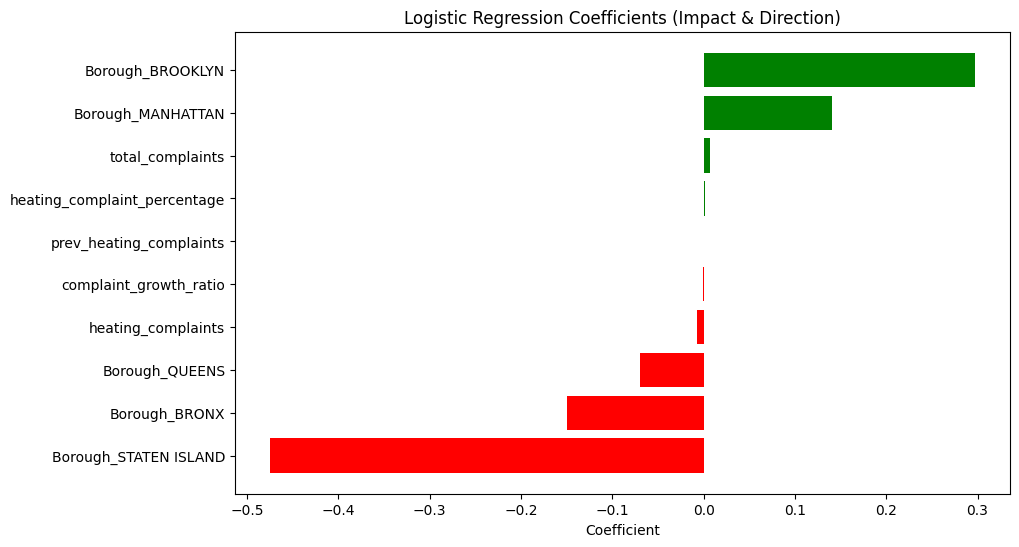

In [ ]:
# Convert to numpy array for plotting
# Keep original (with sign)
coef_values_signed = np.array(coefficients)

# Sort features by importance
indices = np.argsort(coef_values_signed)[::-1]  # High to low


# Plot
plt.figure(figsize=(10,6))
plt.barh(range(len(coef_values_signed)), coef_values_signed[indices], align='center', color=['green' if val > 0 else 'red' for val in coef_values_signed[indices]])
plt.yticks(range(len(coef_values_signed)), np.array(feature_names)[indices])
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients (Impact & Direction)')
plt.gca().invert_yaxis()
plt.show()

#### Confusion Matrix

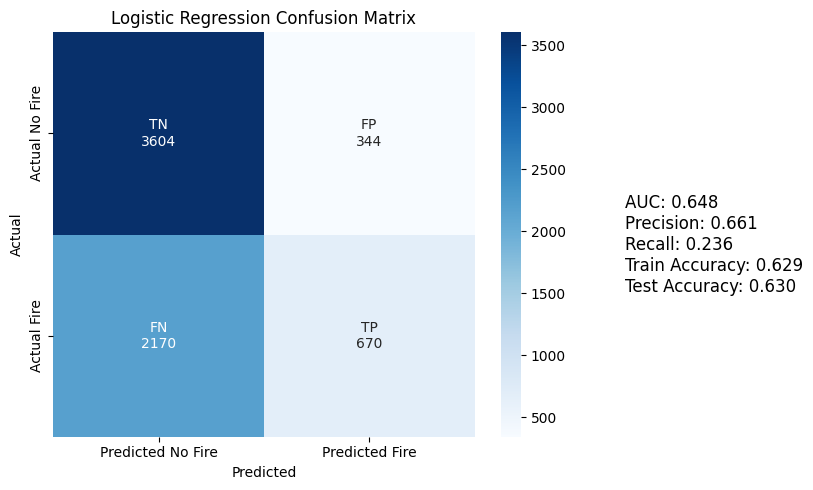

In [ ]:
# Convert predictions to Pandas
preds_pd = predictions.select("fire_occurred", "prediction").toPandas()

# Assume preds_pd has columns: fire_occurred, prediction
cm = confusion_matrix(preds_pd["fire_occurred"], preds_pd["prediction"])

# Define labels for each cell (with counts + tag)
group_labels = [
    f'TN\n{cm[0,0]}',
    f'FP\n{cm[0,1]}',
    f'FN\n{cm[1,0]}',
    f'TP\n{cm[1,1]}'
]
group_labels = np.asarray(group_labels).reshape(2,2)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=group_labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted No Fire', 'Predicted Fire'],
            yticklabels=['Actual No Fire', 'Actual Fire'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')


metrics_text = (
    f"AUC: {auc:.3f}\n"
    f"Precision: {precision:.3f}\n"
    f"Recall: {recall:.3f}\n"
    f"Train Accuracy: {train_accuracy:.3f}\n"
    f"Test Accuracy: {accuracy:.3f}"
)

plt.gcf().text(1.05, 0.5, metrics_text, fontsize=12, va='center')

plt.tight_layout()
plt.show()

#### Heatmap

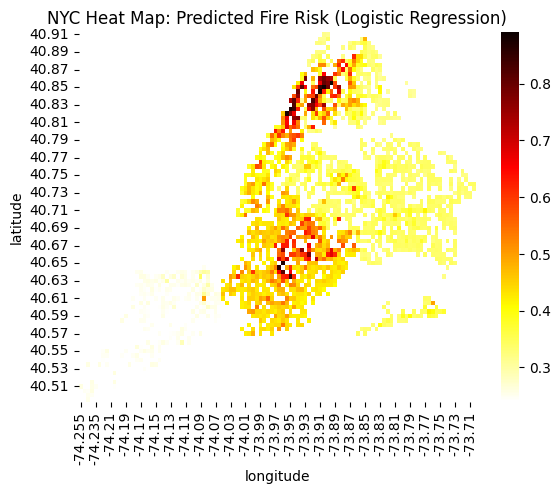

In [ ]:
avg_prob_df = predictions.groupBy("region_id", "latitude", "longitude").agg(
    avg("fire_risk_prob").alias("avg_fire_risk_prob")
)

# Convert to pandas
df_pd = avg_prob_df.toPandas()

pivot_table = df_pd.pivot_table(
    index="latitude",
    columns="longitude",
    values="avg_fire_risk_prob",  # or fire_count
    aggfunc="mean"
)

sns.heatmap(pivot_table.iloc[::-1, ::-1], cmap="hot_r")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("NYC Heat Map: Predicted Fire Risk (Logistic Regression)")
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap
from google.colab import files

# Generate map: the center is the Statue of Liberty
m = folium.Map(location=[40.75, -73.97], zoom_start=11)

heat_data = [[
    float(row['latitude']) + LAT_LONG_GAP/2, float(row['longitude']) + LAT_LONG_GAP/2, row['avg_fire_risk_prob']]
             for index, row in df_pd.iterrows()]

# add heatmap
HeatMap(heat_data, radius=8).add_to(m)

# save resulted map
m.save("ny_predict_fire_risk_heatmap.html")
files.download("ny_predict_fire_risk_heatmap.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## No borough Logistic Regresion

In [ ]:
assembler_no_borough = VectorAssembler(
    inputCols=numerical_features,
    outputCol="features"
)


lr_no_borough = LogisticRegression(
    labelCol="fire_occurred",
    featuresCol="features"
)

pipeline_no_borough = Pipeline(stages=[
    assembler_no_borough,
    lr_no_borough
])

model_no_borough = pipeline_no_borough.fit(train_df)

predictions_no_borough = model_no_borough.transform(test_df)
train_predictions_no_borough = model_no_borough.transform(train_df)

predictions_no_borough = predictions_no_borough.withColumn(
    "fire_risk_prob",
    extract_fire_prob_udf(col("probability"))
)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="fire_occurred")
auc_no_borough = evaluator.evaluate(predictions_no_borough)
print(f"AUC without Borough: {auc_no_borough:.3f}")

In [ ]:
predictions_no_borough.groupBy("fire_occurred", "prediction").count().show()

In [ ]:
# Access LogisticRegressionModel inside the pipeline
lr_model_no_borough = model_no_borough.stages[-1]

coefficients_no_borough = lr_model_no_borough.coefficients


# Print coefficients with feature names
for name, coef in zip(numerical_features, lr_model_no_borough.coefficients):
    print(f"{name}: {coef:.4f}")

In [ ]:
precision_nb = precision_evaluator.evaluate(predictions_no_borough)
recall_nb = recall_evaluator.evaluate(predictions_no_borough)
accuracy_nb = accuracy_evaluator.evaluate(predictions_no_borough)
train_accuracy_nb = accuracy_evaluator.evaluate(train_predictions_no_borough)

print(f"Precision: {precision_nb:.3f}")
print(f"Recall: {recall_nb:.3f}")
print(f"Train Accuracy: {train_accuracy_nb:.3f}")
print(f"Test Accuracy: {accuracy_nb:.3f}")

Precision: 0.675
Recall: 0.194
Train Accuracy: 0.629
Test Accuracy: 0.624


### Visualizations

In [ ]:
# Convert to numpy array for plotting
# Keep original (with sign)
coef_values_signed_nb = np.array(coefficients_no_borough)

# Sort features by importance
indices_nb = np.argsort(coef_values_signed_nb)[::-1]  # High to low


# Plot
plt.figure(figsize=(10,6))
plt.barh(range(len(coef_values_signed_nb)), coef_values_signed_nb[indices_nb], align='center', color=['green' if val > 0 else 'red' for val in coef_values_signed_nb[indices_nb]])
plt.yticks(range(len(coef_values_signed_nb)), np.array(numerical_features)[indices_nb])
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients (Impact & Direction)')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Convert predictions to Pandas
preds_pd = predictions_no_borough.select("fire_occurred", "prediction").toPandas()

# Assume preds_pd has columns: fire_occurred, prediction
cm = confusion_matrix(preds_pd["fire_occurred"], preds_pd["prediction"])

# Define labels for each cell (with counts + tag)
group_labels = [
    f'TN\n{cm[0,0]}',
    f'FP\n{cm[0,1]}',
    f'FN\n{cm[1,0]}',
    f'TP\n{cm[1,1]}'
]
group_labels = np.asarray(group_labels).reshape(2,2)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=group_labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted No Fire', 'Predicted Fire'],
            yticklabels=['Actual No Fire', 'Actual Fire'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix (No Boroughs)')


metrics_text = (
    f"AUC: {auc_no_borough:.3f}\n"
    f"Precision: {precision_nb:.3f}\n"
    f"Recall: {recall_nb:.3f}\n"
    f"Train Accuracy: {train_accuracy_nb:.3f}\n"
    f"Test Accuracy: {accuracy_nb:.3f}"
)

plt.gcf().text(1.05, 0.5, metrics_text, fontsize=12, va='center')

plt.tight_layout()
plt.show()

In [ ]:
nb_avg_prob_df = predictions_no_borough.groupBy("region_id", "latitude", "longitude").agg(
    avg("fire_risk_prob").alias("avg_fire_risk_prob")
)

# Convert to pandas
nb_df_pd = nb_avg_prob_df.toPandas()

nb_pivot_table = nb_df_pd.pivot_table(
    index="latitude",
    columns="longitude",
    values="avg_fire_risk_prob",  # or fire_count
    aggfunc="mean"
)

sns.heatmap(pivot_table.iloc[::-1, ::-1], cmap="hot_r")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("NYC Heat Map: Predicted Fire Risk")
plt.show()

# Part 7. Training a Random Forest Model

In [ ]:
assembler_rf = VectorAssembler(
    inputCols=numerical_features + ["BoroughVec"],
    outputCol="features"
)

rf = RandomForestClassifier(
    labelCol="fire_occurred",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    probabilityCol="probability"
)

pipeline_rf = Pipeline(stages=[
    borough_indexer,    # Stage 0
    borough_encoder,    # Stage 1
    assembler_rf,       # Stage 2
    rf                  # Stage 3
])

In [ ]:
model_rf = pipeline_rf.fit(train_df)

predictions_rf = model_rf.transform(test_df)
train_predictions_rf = model_rf.transform(train_df)

In [ ]:
predictions_rf = predictions_rf.withColumn(
    "fire_risk_prob",
    extract_fire_prob_udf(col("probability"))
)

In [ ]:
auc_rf = evaluator.evaluate(predictions_rf)
print(f"AUC (Random Forest with Borough): {auc_rf:.3f}")

AUC (Random Forest with Borough): 0.654


In [ ]:
predictions_rf.groupBy("fire_occurred", "prediction").count().show()

+-------------+----------+-----+
|fire_occurred|prediction|count|
+-------------+----------+-----+
|            1|       0.0| 1869|
|            0|       0.0| 3319|
|            1|       1.0|  971|
|            0|       1.0|  629|
+-------------+----------+-----+



In [ ]:
# Access the trained RandomForestModel inside the pipeline
rf_model = model_rf.stages[-1]

# Get the Borough categories from the StringIndexer stage
borough_categories = model_rf.stages[0].labels  # Stage 0 is borough_indexer

# Build full feature name list
feature_names = numerical_features + [f"Borough_{cat}" for cat in borough_categories]

# Print feature importances
importances = rf_model.featureImportances

for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

total_complaints: 0.2855
heating_complaints: 0.1885
heating_complaint_percentage: 0.1420
complaint_growth_ratio: 0.0923
prev_heating_complaints: 0.1772
Borough_QUEENS: 0.0276
Borough_BROOKLYN: 0.0474
Borough_BRONX: 0.0189
Borough_MANHATTAN: 0.0126
Borough_STATEN ISLAND: 0.0081


In [ ]:
#Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="fire_occurred",
    predictionCol="prediction",
    metricName="precisionByLabel",
    metricLabel=1.0  # <--- THIS makes it measure precision for fire (label 1)
)

#Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="fire_occurred",
    predictionCol="prediction",
    metricName="recallByLabel",
    metricLabel=1.0
)

# Calculate
precision_rf = precision_evaluator.evaluate(predictions_rf)
recall_rf = recall_evaluator.evaluate(predictions_rf)
accuracy_rf = accuracy_evaluator.evaluate(predictions_rf)
train_accuracy_rf = accuracy_evaluator.evaluate(train_predictions_rf)

print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"Train Accuracy: {train_accuracy_rf:.3f}")
print(f"Test Accuracy: {accuracy_rf:.3f}")

Precision: 0.607
Recall: 0.342
Train Accuracy: 0.681
Test Accuracy: 0.632


## Visualizations

### Feature importances

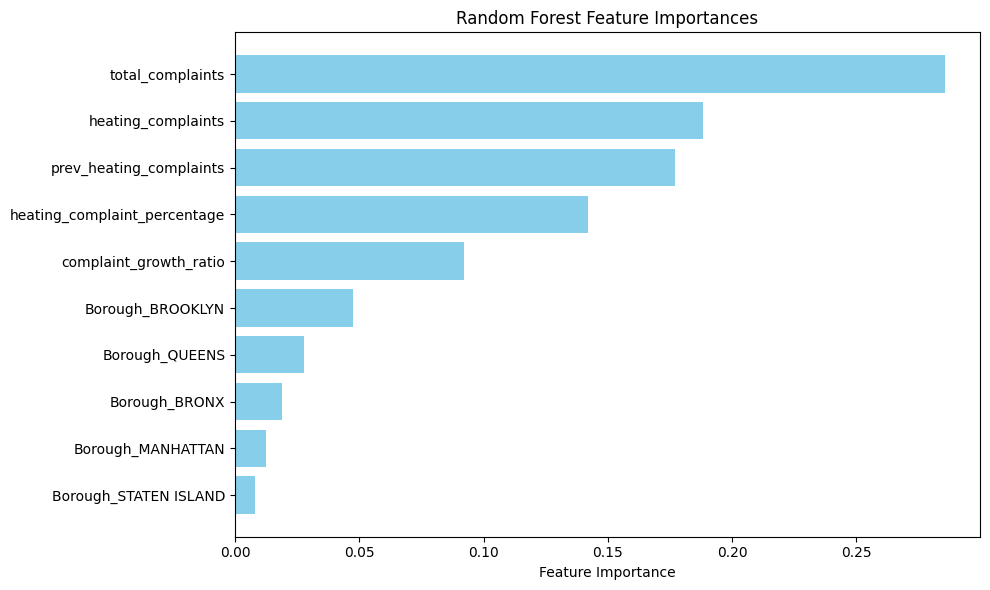

In [ ]:
importances = rf_model.featureImportances.toArray()
indices = np.argsort(importances)  # Sort low → high for horizontal bar

plt.figure(figsize=(10,6))
plt.barh(range(len(importances)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

### Confusion Matrix

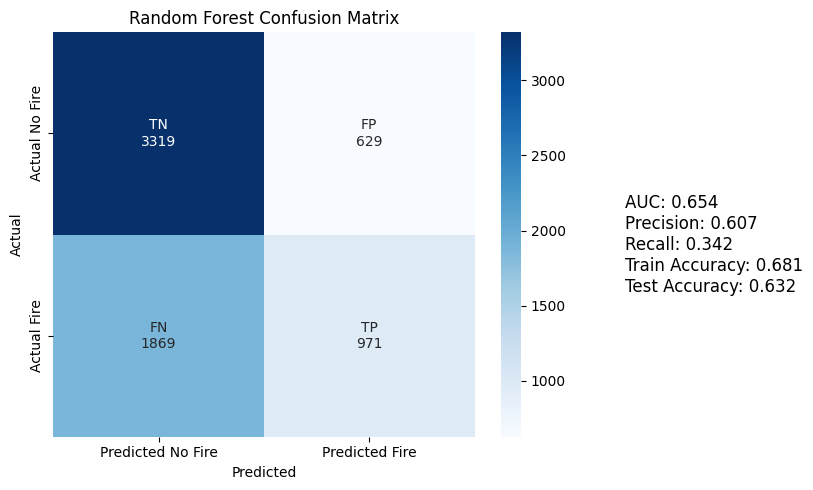

In [ ]:
# Convert predictions to Pandas
preds_pd = predictions_rf.select("fire_occurred", "prediction").toPandas()

# Assume preds_pd has columns: fire_occurred, prediction
cm = confusion_matrix(preds_pd["fire_occurred"], preds_pd["prediction"])

# Define labels for each cell (with counts + tag)
group_labels = [
    f'TN\n{cm[0,0]}',
    f'FP\n{cm[0,1]}',
    f'FN\n{cm[1,0]}',
    f'TP\n{cm[1,1]}'
]
group_labels = np.asarray(group_labels).reshape(2,2)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=group_labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted No Fire', 'Predicted Fire'],
            yticklabels=['Actual No Fire', 'Actual Fire'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')


metrics_text = (
    f"AUC: {auc_rf:.3f}\n"
    f"Precision: {precision_rf:.3f}\n"
    f"Recall: {recall_rf:.3f}\n"
    f"Train Accuracy: {train_accuracy_rf:.3f}\n"
    f"Test Accuracy: {accuracy_rf:.3f}"
)

plt.gcf().text(1.05, 0.5, metrics_text, fontsize=12, va='center')

plt.tight_layout()
plt.show()

### Heatmap

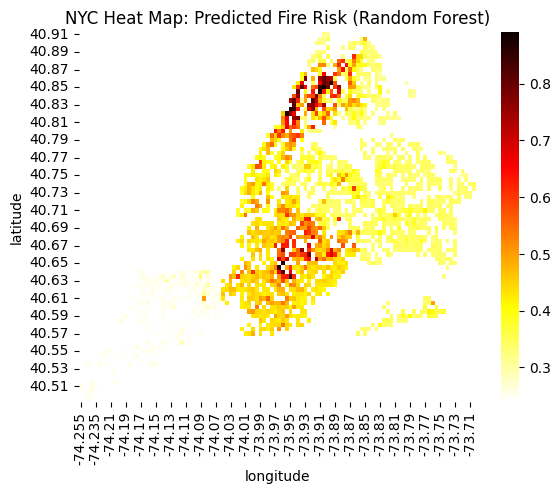

In [ ]:
rf_avg_prob_df = predictions_rf.groupBy("region_id", "latitude", "longitude").agg(
    avg("fire_risk_prob").alias("avg_fire_risk_prob")
)
# Convert to pandas
rf_df_pd = rf_avg_prob_df.toPandas()

rf_pivot_table = rf_df_pd.pivot_table(
    index="latitude",
    columns="longitude",
    values="avg_fire_risk_prob",  # or fire_count
    aggfunc="mean"
)

sns.heatmap(rf_pivot_table.iloc[::-1, ::-1], cmap="hot_r")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("NYC Heat Map: Predicted Fire Risk (Random Forest)")
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap
from google.colab import files

# Generate map: the center is the Statue of Liberty
m = folium.Map(location=[40.75, -73.97], zoom_start=11)

heat_data = [
    [float(row['latitude']) + LAT_LONG_GAP/2, float(row['longitude']) + LAT_LONG_GAP/2, row['avg_fire_risk_prob']]
    for index, row in rf_df_pd.iterrows()]

# add heatmap
HeatMap(heat_data, radius=8).add_to(m)

# save resulted map
m.save("ny_predict_fire_risk_heatmap_random_forest.html")
files.download("ny_predict_fire_risk_heatmap_random_forest.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>